Autoencoders are an unsupervised neural network and they consists of 2 parts - encoder and decoder.

**input --> Encoder --> "CODE" (bottleneck) --> Decoder --> output**

**Encoder** takes some *input* (original image) and learns how to efficiently compress and encode that data into smth that we call the **"CODE"**.

Then we have a **decoder** that learns how to reconstruct that encoded data representation 

and that *output* is as similar to the original data as possible.

Effectively, an AE learns  to recognize wich aspects of observable data are relevant, and limit noise in data that can be discarded. For ex, we can derive the required features of the image by removing noise. 

"CODE" can be used to change input (image) somehow (for ex, change resolution or color of an image).

Mostly use to reconstruct original image from the noisy version  of it.

1. **Encoder** (conventional feed-forward neural network)itself compresses the input into a latent space repesentation. So, we have multiple layers that represent the encoder (each one a little smaller than  the other).
2. The most compressed version, that`s called the **"CODE"**, that's also known as the **bottleneck** (compressed representation of the model’s input).
3. Then we have the **decoder** (feed-forward neural network but the dimension of the data increases), which is reconstructed from that bottleneck (latent space) representation to genetate the output. 

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import ToTensor
from PIL import Image
import os
import pandas as pd
import matplotlib.pyplot as plt
from torchvision import transforms
import random


e:\anaconda3\Lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] Не найдена указанная процедура'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


Check cuda is available

In [2]:

print(torch.cuda.current_device())    # The ID of the current GPU.
print(torch.cuda.get_device_name(id))  # The name of the specified GPU, where id is an integer.
print(torch.cuda.device(id))           # The memory address of the specified GPU, where id is an integer.
print(torch.cuda.device_count())       # The amount of GPUs that are accessible.

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


0
NVIDIA GeForce MX130
1


Hyperparameters:

In [3]:
epochs = 35
batch_size = 32
img_size = 32
hidden_layer = 256
bottleneck = 2


In [4]:

class SportBallsDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.data_info = self.load_data_info()

    def __len__(self):
        return len(self.data_info)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.data_info.iloc[idx, 0] + '.png') 
        if not os.path.exists(img_name):
            print(f"File not found: {img_name}")
        image = Image.open(img_name).convert('RGB')
        label = int(self.data_info.iloc[idx, 1])  # iloc - is used to access the data at a specific location in the DataFrame
        label = torch.tensor(label, dtype=torch.long)  # Convert to tensor
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

# read lables
    def load_data_info(self):
        labels_path = os.path.join(self.root_dir, 'labels.csv')
        data_info = pd.read_csv(labels_path, header=None)
        return data_info



In [5]:
# Transforms for resizing and normalization
transform = transforms.Compose([    # performs a series of image transformations
    transforms.Resize((img_size, img_size)),    # resizes the image to the specified dimensions (img_size, img_size)
    transforms.ToTensor(),  # Converts the image (which is initially in PIL Image format) into a PyTorch tensor.
])

# Load datasets
train_dataset = SportBallsDataset(root_dir='Sportballs/Train/', transform=transform)    # transform - Standardization of Input
test_dataset = SportBallsDataset(root_dir='Sportballs/Test/', transform=transform)

# shuffle - refers to the randomization of the order of data samples before each epoch (iteration over the entire dataset)
# DataLoader - to create batches of data from a dataset (bc memory), for shuffling, for parallelizing  
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Print the length of the datasets
print(f"Number of training examples: {len(train_dataset)}")
print(f"Number of test examples: {len(test_dataset)}")

Number of training examples: 10000
Number of test examples: 100


Lables:

0 - baseball

1- basketball

2 - volleyball

3 - soccerball

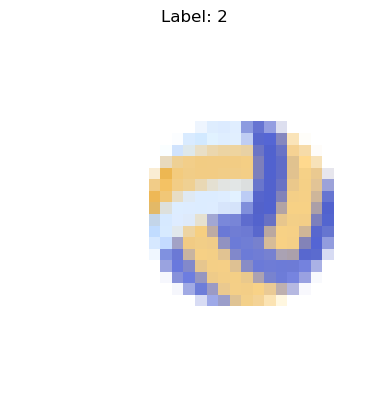

In [6]:
def show_random_image_with_label(dataset):
    idx = random.randint(0, len(dataset) - 1)  # Randomly select an index
    image, label = dataset[idx]  # Get the image and label
    image = image.permute(1, 2, 0)  # Change dimensions to (H, W, C) for displaying

    plt.imshow(image)
    plt.title(f"Label: {label.item()}")
    plt.axis('off')
    plt.show()

# Show a random image with its label from the train dataset
show_random_image_with_label(train_dataset)

# Autoencoder model

In [7]:

class Autoencoder(nn.Module):
    def __init__(self, img_size, hidden_layer, bottleneck):
        super(Autoencoder, self).__init__()
           
        # the encoder section reduces the dimensionality of the data sequentially
        
        self.encoder = nn.Sequential(   # nn.Sequential - A sequential container.Modules will be added to it in the order they are passed in the constructor. Alternatively, an OrderedDict of modules can be passed in
        # The encoder starts with 32*32 nodes in a Linear layer followed by a ReLU layer, and it goes on until the dimensionality is reduced to 2 nodes
            nn.Linear(img_size * img_size * 3, hidden_layer),
            nn.ReLU(),  # nn.ReLU - Applies the rectified linear unit function element-wise.
            nn.Linear(hidden_layer, bottleneck) # nn.Linear - Applies a linear transformation to the incoming data
        )
        
        # the dimensionality of the data is linearly increased to the original input size, in order to reconstruct the input.
        
        self.decoder = nn.Sequential(   
            nn.Linear(bottleneck, hidden_layer),
            nn.ReLU(),
            nn.Linear(hidden_layer, img_size * img_size * 3),
            # The decryptor architecture uses a Sigmoid Layer to range the values between 0 and 1 only
            nn.Sigmoid()
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)   # is flattening the tensor, this is because the Linear layer only accepts a vector (1d array)
        z = self.encoder(x)
        x = self.decoder(z)
        x = x.view(x.size(0), 3, 32, 32)    # x.size(0) - retrieves the size of the first dimension of x, which is the batch size
        return x
    

# Instantiate and train the autoencoder
model = Autoencoder(img_size, hidden_layer, bottleneck).to(device)

# In autoencoders, MSE loss is commonly used because it effectively measures the difference between the original input and the reconstructed output
criterion = nn.MSELoss()    # The mean squared error pushes the network to pay special attention to those pixel values its estimate is far away

# The Adam optimizer is also an optimization techniques used for machine learning and deep learning, and comes under gradient decent algorithm
optimizer = optim.Adam(model.parameters(), lr=1e-3)



In [8]:
# Training loop
output = []
for epoch in range(epochs):
    model.train()   # set the model to training mode
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        # Output of Autoencoder
        outputs = model(images)
        
        # Calculating the loss function
        loss = criterion(outputs, images)
        
        # The gradients are set to zero,
        # the gradient is computed and stored.
        # .step() performs parameter update
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
 
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

# Test and calculate reconstruction loss
model.eval()    # set the model to evaluation mode
test_loss = 0

with torch.no_grad():   # temporarily sets all the requires_grad flags to False. when don’t need to compute gradients or perform backpropagation.
    for images, labels in test_loader:
        images = images.to(device)
        
        # are passing the input tensor images through the neural network model model to get the output predictions
        outputs = model(images)
        loss = criterion(outputs, images)
        
        # The .item() method in PyTorch is used to get the value of a single-element tensor as a standard Python number.
        # use since computing the loss, the result will be a tensor with one element representing the loss value
        test_loss += loss.item()

test_loss /= len(test_loader)
print(f'Test Reconstruction Loss: {test_loss:.4f}')

Epoch [1/35], Loss: 0.0109
Epoch [2/35], Loss: 0.0155
Epoch [3/35], Loss: 0.0115
Epoch [4/35], Loss: 0.0118
Epoch [5/35], Loss: 0.0115
Epoch [6/35], Loss: 0.0131
Epoch [7/35], Loss: 0.0106
Epoch [8/35], Loss: 0.0151
Epoch [9/35], Loss: 0.0077
Epoch [10/35], Loss: 0.0095
Epoch [11/35], Loss: 0.0109
Epoch [12/35], Loss: 0.0137
Epoch [13/35], Loss: 0.0119
Epoch [14/35], Loss: 0.0134
Epoch [15/35], Loss: 0.0141
Epoch [16/35], Loss: 0.0142
Epoch [17/35], Loss: 0.0127
Epoch [18/35], Loss: 0.0143
Epoch [19/35], Loss: 0.0110
Epoch [20/35], Loss: 0.0113
Epoch [21/35], Loss: 0.0115
Epoch [22/35], Loss: 0.0091
Epoch [23/35], Loss: 0.0107
Epoch [24/35], Loss: 0.0071
Epoch [25/35], Loss: 0.0098
Epoch [26/35], Loss: 0.0124
Epoch [27/35], Loss: 0.0102
Epoch [28/35], Loss: 0.0117
Epoch [29/35], Loss: 0.0087
Epoch [30/35], Loss: 0.0081
Epoch [31/35], Loss: 0.0122
Epoch [32/35], Loss: 0.0108
Epoch [33/35], Loss: 0.0103
Epoch [34/35], Loss: 0.0130
Epoch [35/35], Loss: 0.0089
Test Reconstruction Loss: 0.0

# Variational Autoencoder model

##### unlike traditional autoencoders, the encoder in a VAE outputs not a single latent vector but the parameters of the latent distribution —  the mean (μ) and the log variance (σ²). This means that for each input sample, the encoder is actually describing a probability distribution, rather than a fixed point.

In [9]:

class VAE(nn.Module):
    def __init__(self, img_size, hidden_layer, bottleneck):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(   # nn.Sequential - A sequential container.Modules will be added to it in the order they are passed in the constructor. Alternatively, an OrderedDict of modules can be passed in
        # The encoder starts with 32*32 nodes in a Linear layer followed by a ReLU layer, and it goes on until the dimensionality is reduced to 4 nodes
            nn.Linear(img_size * img_size * 3, hidden_layer),
            nn.ReLU(),  # nn.ReLU - Applies the rectified linear unit function element-wise.
            nn.Linear(hidden_layer, 4)  # 2 for mean and 2 for log variance
        )
        self.decoder = nn.Sequential(
            nn.Linear(bottleneck, hidden_layer),
            nn.ReLU(),
            nn.Linear(hidden_layer, img_size * img_size * 3),
            nn.Sigmoid()    # The decryptor architecture uses a Sigmoid Layer to range the values between 0 and 1 only
        )

    def sampling(self, mu, logvar):
        std = torch.exp(0.5 * logvar)   # standard deviation of the distribution
    # The factor 0.5 is used because the variance is the square of the standard deviation, and taking the exponent of half the log-variance gives the standard deviation
        eps = torch.randn_like(std) # eps is a tensor of the same shape as std sampled from a standard normal distribution (mean 0, variance 1)
        return eps.mul(std).add_(mu)

# forward() - method outlines how input data flows through the network layers to produce output
    def forward(self, x):
        x = x.view(x.size(0), -1)   # is flattening the tensor, this is because the Linear layer only accepts a vector (1d array)
        h = self.encoder(x)
        mu, logvar = h[:, :2], h[:, 2:] # to split a single tensor h into two separate tensors, mu and logvar
        z = self.sampling(mu, logvar)
        x = self.decoder(z)
        x = x.view(x.size(0), 3, img_size, img_size)
        return x, mu, logvar

# In VAE, the loss function consists of two main components: 
# a reconstruction loss and a regularization term known as the Kullback-Leibler (KL) divergence
def vae_loss(recon_x, x, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum') # binary_cross_entropy computes the binary cross-entropy loss between recon_x and x
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

# Instantiate and train the VAE
vae_model = VAE(img_size, hidden_layer, bottleneck).to(device)

# The Adam optimizer is also an optimization techniques used for machine learning and deep learning, and comes under gradient decent algorithm
vae_optimizer = optim.Adam(vae_model.parameters(), lr=1e-3)




In [10]:
# Training loop for VAE
for epoch in range(epochs):
    vae_model.train()
    for images, labels in train_loader:
        images = images.to(device)
        recon_images, mu, logvar = vae_model(images)
        
        # Calculating the loss function
        loss = vae_loss(recon_images, images, mu, logvar)
        
        # The gradients are set to zero,
        # the gradient is computed and stored.
        # .step() performs parameter update
        vae_optimizer.zero_grad()
        loss.backward()
        vae_optimizer.step()
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

# Test and calculate reconstruction loss for VAE
vae_model.eval()
vae_test_loss = 0
with torch.no_grad():   # # temporarily sets all the requires_grad flags to False. when don’t need to compute gradients or perform backpropagation
    for images, labels in test_loader:
        images = images.to(device)
        recon_images, mu, logvar = vae_model(images)
        loss = vae_loss(recon_images, images, mu, logvar)
        
        # The .item() method in PyTorch is used to get the value of a single-element tensor as a standard Python number.
        # use since computing the loss, the result will be a tensor with one element representing the loss value
        vae_test_loss += loss.item()

vae_test_loss /= len(test_loader.dataset)
print(f'VAE Test Reconstruction Loss: {vae_test_loss:.4f}')

Epoch [1/35], Loss: 8105.6201
Epoch [2/35], Loss: 7704.7095
Epoch [3/35], Loss: 7843.3989
Epoch [4/35], Loss: 9006.6162
Epoch [5/35], Loss: 8760.7256
Epoch [6/35], Loss: 7968.1826
Epoch [7/35], Loss: 8444.7500
Epoch [8/35], Loss: 7191.5464
Epoch [9/35], Loss: 5976.9736
Epoch [10/35], Loss: 8683.1426
Epoch [11/35], Loss: 7405.7998
Epoch [12/35], Loss: 8796.9385
Epoch [13/35], Loss: 7699.5532
Epoch [14/35], Loss: 8463.5830
Epoch [15/35], Loss: 7364.3457
Epoch [16/35], Loss: 6479.0610
Epoch [17/35], Loss: 6233.1514
Epoch [18/35], Loss: 6666.8252
Epoch [19/35], Loss: 7286.4028
Epoch [20/35], Loss: 7181.9121
Epoch [21/35], Loss: 6821.8511
Epoch [22/35], Loss: 7453.7754
Epoch [23/35], Loss: 8537.7646
Epoch [24/35], Loss: 6721.0571
Epoch [25/35], Loss: 7393.6558
Epoch [26/35], Loss: 7457.8867
Epoch [27/35], Loss: 7050.5312
Epoch [28/35], Loss: 7219.1602
Epoch [29/35], Loss: 6949.8765
Epoch [30/35], Loss: 5968.9985
Epoch [31/35], Loss: 7476.0020
Epoch [32/35], Loss: 7327.2510
Epoch [33/35], Lo

In [11]:
def compute_accuracy(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    # accuracy = 0
    # for epoch in range(epochs):
    with torch.no_grad():
        
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            z = model.encoder(images.view(images.size(0), -1))  # is flattening the tensor, this is because the Linear layer only accepts a vector (1d array)
            # recon_images = model.decoder(z)
            _, predicted = torch.max(z.data, 1) # z.data - take only values - we want to find the class with the highest score
            total += labels.size(0) # corresponds to the batch size. gives the number of items
            correct += (predicted == labels).sum().item()
            # accuracy = correct / total
            # print(f'Epoch [{epoch+1}/{epochs}], Accuracy: {accuracy:.4f}')
            return correct / total

# Calculate accuracy for Autoencoder
ae_accuracy = compute_accuracy(model, test_loader)
print(f'Autoencoder Accuracy: {ae_accuracy:.4f}')

# Calculate accuracy for VAE
vae_accuracy = compute_accuracy(vae_model, test_loader)
print(f'VAE Accuracy: {vae_accuracy:.4f}')


Autoencoder Accuracy: 0.3750
VAE Accuracy: 0.2500


Reconstructed Autoencoder:


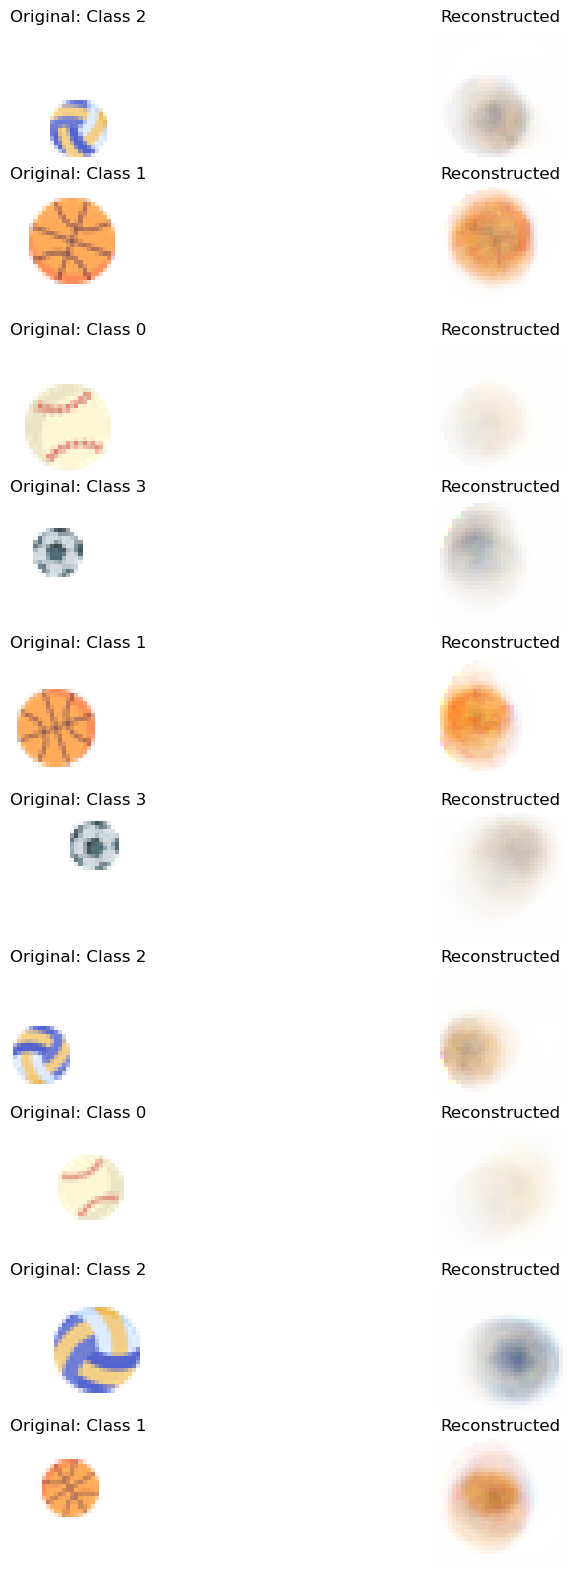

Reconstructed VAE:


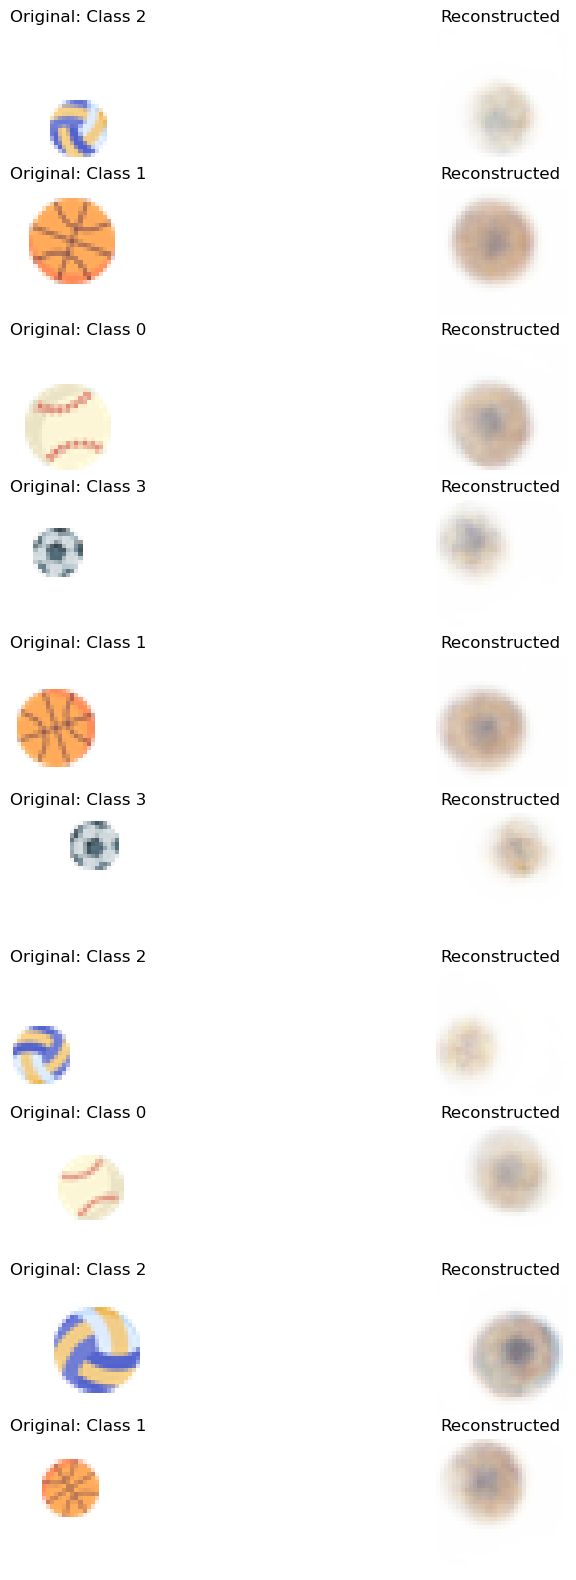

In [12]:

def plot_examples(model, dataset, num_examples=10, is_vae=False):
    model.eval()
    fig, axes = plt.subplots(num_examples, 2, figsize=(10, 20))
    with torch.no_grad():
        for i in range(num_examples):
            img, label = dataset[i]
            img = img.unsqueeze(0).to(device)
            if is_vae:
                recon_img, _, _ = model(img)
            else:
                recon_img = model(img)
            img = img.squeeze().cpu().numpy().transpose(1, 2, 0)
            recon_img = recon_img.squeeze().cpu().numpy().transpose(1, 2, 0)
            axes[i, 0].imshow(img)
            axes[i, 0].set_title(f"Original: Class {label.item()}")
            axes[i, 0].axis('off')
            axes[i, 1].imshow(recon_img)
            axes[i, 1].set_title("Reconstructed")
            axes[i, 1].axis('off')
    plt.show()

# Plot examples for Autoencoder
print('Reconstructed Autoencoder:')
plot_examples(model, test_dataset, num_examples=10)

# Plot examples for VAE
print('Reconstructed VAE:')
plot_examples(vae_model, test_dataset, num_examples=10, is_vae=True)


# OUTPUTS:
Actual accuracy:
- Autoencoder Accuracy: 0.3750
- VAE Accuracy: 0.2500

But I had accuracy apx.40% for each model once. However, these models are not directly for classification and accuracy doesn`t mean a lot (if I understand correctly..).

Looking on original and reconstructed images, it seems that standart autoencoder works better, but trying to train the both model several times, I would say that they have quite similar result.

Reconstructed result is not so accurate since I use very simle linear model. I thing that I can improve the models by adding more layers and even replace Linear on Conv.


